<h1> Time series prediction, end-to-end </h1>

This notebook illustrates several models to find the next value of a time-series:
<ol>
<li> DNN
<li> CNN 
<li> LSTM
</ol>

<p>
<b>Note:</b>
See [(Time series prediction with RNNs and TensorFlow)](../05_artandscience/d_customestimator.ipynb) for a very similar example, except that it works with multiple short sequences.

In [1]:
# change these to try this notebook out
BUCKET = 'cloud-training-demos-ml'
PROJECT = 'cloud-training-demos'
REGION = 'us-central1'
SEQ_LEN = 50

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['SEQ_LEN'] = str(SEQ_LEN)

In [3]:
%%datalab project set -p $PROJECT

<h3> Simulate some time-series data </h3>

Essentially a set of sinusoids with random amplitudes and frequencies.

In [4]:
import tensorflow as tf
print tf.__version__

1.2.1


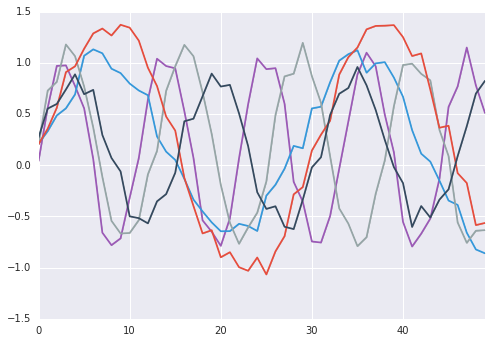

In [5]:
import numpy as np
import seaborn as sns

def create_time_series():
  freq = (np.random.random()*0.5) + 0.1  # 0.1 to 0.6
  ampl = np.random.random() + 0.5  # 0.5 to 1.5
  noise = [np.random.random()*0.3 for i in xrange(SEQ_LEN)] # -0.3 to +0.3 uniformly distributed
  x = np.sin(np.arange(0,SEQ_LEN) * freq) * ampl + noise
  return x

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in xrange(0, 5):
  sns.tsplot( create_time_series(), color=flatui[i%len(flatui)] );  # 5 series

In [6]:
def to_csv(filename, N):
  with open(filename, 'w') as ofp:
    for lineno in xrange(0, N):
      seq = create_time_series()
      line = ",".join(map(str, seq))
      ofp.write(line + '\n')

import os
try:
  os.makedirs('data/sines/')
except OSError:
  pass
to_csv('data/sines/train-1.csv', 1000)  # 1000 sequences
to_csv('data/sines/valid-1.csv', 250)

In [7]:
!head -5 data/sines/*-1.csv

==> data/sines/train-1.csv <==
0.0748873916376,0.447740615977,0.717589472426,0.858772978179,0.608724336456,0.302446739938,0.0280110368029,-0.531982131283,-0.468104981652,-0.494012545404,-0.126079933123,0.199709971324,0.553663376401,0.778562711683,0.767834294938,0.671534068434,0.392766129638,-0.219178436795,-0.377270233974,-0.617684784386,-0.557375138859,-0.13441895655,0.179344392905,0.694238738373,0.742613945325,0.802871888808,0.527062793736,0.315789725344,-0.25938141901,-0.439878866953,-0.715512272927,-0.484315619215,-0.0648125337349,0.334649573669,0.746666758013,0.70962911156,0.743632509136,0.567667711174,0.370128693895,-0.188000053146,-0.593534425513,-0.717821580268,-0.430561591089,-0.0302571755165,0.301924685353,0.505925169202,0.911040529317,0.881595070159,0.565253317297,0.301532968936
0.0722535254277,0.297084336785,0.677379412971,0.759013114097,1.05396950396,1.02315766096,1.09967887116,0.992123910538,0.853346457288,0.381293389615,0.14601012707,0.0555048644091,-0.335915951739,-0.52

<h3> Train model locally </h3>

Make sure the code works as intended.

In [ ]:
%bash
# run module as-is
DATADIR=$(pwd)/data/sines
OUTDIR=$(pwd)/trained/sines
echo $DATADIR $OUTDIR
rm -rf $OUTDIR
export PYTHONPATH=${PYTHONPATH}:${PWD}/sinemodel
python -m trainer.task \
   --train_data_paths="${DATADIR}/train-1.csv" \
   --eval_data_paths="${DATADIR}/valid-1.csv"  \
   --output_dir=${OUTDIR} \
   --job-dir=./tmp \
   --model=lstmN --train_steps=10 --sequence_length=$SEQ_LEN

Try out online prediction.  This is how the REST API will work after you train on Cloud ML Engine

In [14]:
%writefile data/sines/test.json
{"rawdata": [0.0748873916376,0.447740615977,0.717589472426,0.858772978179,0.608724336456,0.302446739938,0.0280110368029,-0.531982131283,-0.468104981652,-0.494012545404,-0.126079933123,0.199709971324,0.553663376401,0.778562711683,0.767834294938,0.671534068434,0.392766129638,-0.219178436795,-0.377270233974,-0.617684784386,-0.557375138859,-0.13441895655,0.179344392905,0.694238738373,0.742613945325,0.802871888808,0.527062793736,0.315789725344,-0.25938141901,-0.439878866953,-0.715512272927,-0.484315619215,-0.0648125337349,0.334649573669,0.746666758013,0.70962911156,0.743632509136,0.567667711174,0.370128693895,-0.188000053146,-0.593534425513,-0.717821580268,-0.430561591089,-0.0302571755165,0.301924685353,0.505925169202,0.911040529317,0.881595070159,0.565253317297]}

Writing data/sines/test.json


In [ ]:
%bash
OUTDIR=$(pwd)/trained/sines
MODEL_DIR=$OUTDIR/export/Servo/$(ls $OUTDIR/export/Servo/)
echo $MODEL_DIR
gcloud ml-engine local predict --model-dir=$MODEL_DIR --json-instances=data/sines/test.json

<h3> Cloud ML Engine </h3>

Now to train on Cloud ML Engine with more data.

In [11]:
import shutil
shutil.rmtree('data/sines', ignore_errors=True)
os.makedirs('data/sines/')
for i in xrange(0,10):
  to_csv('data/sines/train-{}.csv'.format(i), 1000)  # 1000 sequences
  to_csv('data/sines/valid-{}.csv'.format(i), 250)

In [ ]:
%bash
gsutil -m rm -rf gs://${BUCKET}/sines/*
gsutil -m cp data/sines/*.csv gs://${BUCKET}/sines

In [ ]:
%bash
for MODEL in cnn dnn lstm lstm2 lstmN; do
  OUTDIR=gs://${BUCKET}/sinewaves/$MODEL
  JOBNAME=sines_${MODEL}_$(date -u +%y%m%d_%H%M%S)
  REGION=us-central1
  gsutil -m rm -rf $OUTDIR
  gcloud ml-engine jobs submit training $JOBNAME \
     --region=$REGION \
     --module-name=trainer.task \
     --package-path=${PWD}/sinemodel/trainer \
     --job-dir=$OUTDIR \
     --staging-bucket=gs://$BUCKET \
     --scale-tier=BASIC_GPU \
     --runtime-version=1.2 \
     -- \
     --train_data_paths="gs://${BUCKET}/sines/train*.csv" \
     --eval_data_paths="gs://${BUCKET}/sines/valid*.csv"  \
     --output_dir=$OUTDIR \
     --train_steps=10000 --sequence_length=$SEQ_LEN --model=$MODEL
done

## Results

When I ran it, these were the RMSEs that I got for different models:

| Model | Sequence length | # of steps | Minutes | RMSE |
| --- | ----| --- | --- | --- | 
| dnn | 50 | 10000 | 17 min | 0.111 |
| cnn | 50 | 10000 | 17 min | 0.098 |
| lstm | 50 | 10000 | 22 min | 0.134 |
| lstm2 | 50 | 10000 | 27 min |0.103 |
| lstmN | 50 | 10000 | 29 min | 0.091 |


Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License